#### Multiclass Classification of J Gene Type

In [1]:
cd ..

/home/romi/projects/cvc


In [2]:
%load_ext autoreload
%autoreload 2

In [161]:
import os, sys
import collections
import lab_notebooks.utils
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import torch

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from cvc import plot_utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

#### Load Data

In [162]:
gene_type = 'J' #'V'
load_csv = False

In [163]:
if gene_type == 'J':
    data_dir = DATA_DIR + "j_gene_embeddings.csv"
    data_dir_full = DATA_DIR + 'jgene_embed_full_data.csv'
    gene_column = 'jGeneName'
    output_path = './jgene_data_embeddings_with_label_and_sequence.csv'
    input_path = './jgene_data_embeddings_with_label_and_sequence.csv'
else:
    data_dir = DATA_DIR + "v_gene_embeddings.csv"
    data_dir_full = DATA_DIR + 'vgene_public_specific_data.csv'
        #'vgene_data_classfy1.csv' #vgene_embed_full_data.csv'
    gene_column = 'vGeneName'
    output_path = './vgene_public_specific_data_embeddings_with_label_and_sequence.csv'
    input_path = './vgene_data_embeddings_with_label_and_sequence.csv'

In [164]:
# read data
gene_data = pd.read_csv(data_dir_full, engine="pyarrow")

In [165]:
gene_data = gene_data[['Sequences', 'Appearances', 'Private_Public_label', gene_column]]
gene_data

,Sequences,Appearances,Private_Public_label,jGeneName
0,CASNPRGFASTDTQYF,1,0,TCRBJ02-03
1,CASSMGQGKTDTQYF,1,0,TCRBJ02-03
2,CATSETDTQYF,6,1,TCRBJ02-03
3,CASSYLRQLDTQYF,1,0,TCRBJ02-03
4,CATSRDSVQSRLDTQYF,1,0,TCRBJ02-03
...,...,...,...,...
1079531,CSVEDRRTSPKNIQYF,1,0,TCRBJ02-04
1079532,CASSLADKNIQYF,1,0,TCRBJ02-04
1079533,CATGADRDSIQYF,1,0,TCRBJ02-04
1079534,CASSYSMLAGGNIQYF,1,0,TCRBJ02-04


In [166]:
collections.Counter(gene_data['Private_Public_label'])

Counter({0: 943758, 1: 135778})

In [167]:
collections.Counter(gene_data[gene_column])

Counter({'TCRBJ02-03': 102612,
         'TCRBJ02-07': 160321,
         'TCRBJ01-01': 123659,
         'TCRBJ02-05': 83612,
         'TCRBJ02-02': 73979,
         'TCRBJ01-05': 79326,
         'TCRBJ01-02': 127798,
         'TCRBJ02-01': 148422,
         'TCRBJ01-03': 39829,
         'TCRBJ02-06': 17070,
         'TCRBJ01-06': 52723,
         'TCRBJ01-04': 51858,
         'TCRBJ02-04': 18327})

#### Create subset with equall distribution of genes

In [168]:
# extract sequences that do not have *
gene_data_to_use = [seq for seq in gene_data['Sequences'] if '*' not in seq]
len(gene_data_to_use)

1049813

In [169]:
gene_data_edit = gene_data

In [170]:
# leave the sequences that do not have *
gene_data_edit = gene_data_edit.loc[gene_data_edit['Sequences'].isin(gene_data_to_use)]
len(gene_data_edit)

1049813

In [171]:
# convert label column to numpy array
gene_label_array = gene_data_edit[gene_column].to_numpy()
print(gene_label_array)

['TCRBJ02-03' 'TCRBJ02-03' 'TCRBJ02-03' ... 'TCRBJ02-04' 'TCRBJ02-04'
 'TCRBJ02-04']


In [172]:
collections.Counter(gene_data_edit[gene_column])

Counter({'TCRBJ02-03': 99472,
         'TCRBJ02-07': 154523,
         'TCRBJ01-01': 121269,
         'TCRBJ02-05': 80593,
         'TCRBJ02-02': 71939,
         'TCRBJ01-05': 76960,
         'TCRBJ01-02': 125596,
         'TCRBJ02-01': 143646,
         'TCRBJ01-03': 39018,
         'TCRBJ02-06': 16673,
         'TCRBJ01-06': 51687,
         'TCRBJ01-04': 50838,
         'TCRBJ02-04': 17599})

In [173]:
# get minimum count
min_value = min(collections.Counter(gene_data_edit[gene_column]).values())
# sample from each group according to minimum count
sampled_data = gene_data_edit.groupby(gene_column, sort=False).apply(lambda x: x.sample(min_value))
sampled_data

Sequences  Appearances  Private_Public_label  \
jGeneName                                                                   
TCRBJ02-03 9695      CASSLGASGTSGFTQYF            1                     0   
           3304      CASSPRTSGRGVDTQYF            1                     0   
           29201       CAWGPPGDSTDTQYF            1                     0   
           50089       CAISESVGSTDTQYF            1                     0   
           36139    CASSFAGTSGSSTDTQYF            1                     0   
...                                ...          ...                   ...   
TCRBJ02-04 1065182  CAWSAPGSGAGAKNIQYF            1                     0   
           1065808      CASSLAGRKNIQYF            2                     1   
           1062353        CSARFPQDIQYF            1                     0   
           1078968    CASTPNYGGFKNIQYF            1                     0   
           1064726       CASSVSDQNIQYF            1                     0   

                     jGeneName  
jGeneName                       
TCRBJ02-03 9695     TCRBJ02-03  
           3304     TCRBJ02-03  
           29201    TCRBJ02-03  
           50089    TCRBJ02-03  
           36139    TCRBJ02-03  
...                        ...  
TCRBJ02-04 1065182  TCRBJ02-04  
           1065808  TCRBJ02-04  
           1062353  TCRBJ02-04  
           1078968  TCRBJ02-04  
           1064726  TCRBJ02-04  

[216749 rows x 4 columns]

In [174]:
collections.Counter(sampled_data[gene_column])

Counter({'TCRBJ02-03': 16673,
         'TCRBJ02-07': 16673,
         'TCRBJ01-01': 16673,
         'TCRBJ02-05': 16673,
         'TCRBJ02-02': 16673,
         'TCRBJ01-05': 16673,
         'TCRBJ01-02': 16673,
         'TCRBJ02-01': 16673,
         'TCRBJ01-03': 16673,
         'TCRBJ02-06': 16673,
         'TCRBJ01-06': 16673,
         'TCRBJ01-04': 16673,
         'TCRBJ02-04': 16673})

#### Embeddings

In [175]:
from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, sampled_data, batch_size=1024, method="mean", layers=[-1])
embed_wrap.embeddings.shape

(216749, 768)

In [176]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()
tcrb_embeddings_adata

AnnData object with n_obs × n_vars = 216749 × 768
    obs: 'Sequences', 'Appearances', 'Private_Public_label', 'jGeneName'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [177]:
df_embeddings = pd.DataFrame(embed_wrap.embeddings)
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.250865,0.142681,-0.109450,-0.846184,0.139322,0.504051,-0.308549,0.354147,-0.040887,-0.557362,...,-0.313677,-0.823121,0.403834,-0.003716,0.079544,0.556326,-0.313829,0.317674,0.857656,-0.246653
1,-0.262795,0.274033,-0.421290,-0.550225,0.356016,0.299977,0.027824,0.268805,0.173191,-0.389741,...,-0.341765,-0.527311,-0.455443,-0.290670,-0.036973,0.161082,-0.475615,0.657492,0.290883,-0.199632
2,-0.300573,0.727345,0.000831,-0.283493,0.170121,0.352162,0.496296,-0.016598,-0.253156,-0.641743,...,-0.045613,-0.695677,0.095868,-0.213269,-0.218220,0.090078,-0.014021,0.393215,-0.343314,0.247537
3,-0.442014,0.363003,-0.563592,-0.536502,0.049448,0.093797,0.158696,0.071407,0.034668,-0.455050,...,0.287669,-0.513884,-0.039472,0.100920,-0.016136,0.524027,0.097585,0.500427,0.419674,-0.231670
4,-0.077024,0.574550,-0.116299,-0.731358,0.267231,0.374076,0.316432,0.214838,0.059598,-0.715420,...,-0.404071,-0.504485,-0.152201,-0.310094,-0.254878,0.254160,-0.356036,0.585389,0.536438,0.355650


In [178]:
# add gene label to dataframe
df_embeddings_with_label = df_embeddings
df_embeddings_with_label[gene_column]=list(tcrb_embeddings_adata.obs[gene_column])
df_embeddings_with_label['Sequences']=list(tcrb_embeddings_adata.obs['Sequences'])

In [179]:
# export embeddings to csvֿ
df_embeddings_with_label.to_csv(output_path)

In [180]:
# # load from csv
if load_csv==True:
    df_embeddings_with_label = pd.read_csv(input_path)
tcrb_embeddings = df_embeddings_with_label.iloc[:,1:-2].to_numpy()
j_gene_array = df_embeddings_with_label.iloc[:,-2].to_numpy()

#### Classification Utils

In [181]:
accuracy_dictionary = {}

In [182]:
TRAIN_RATIO = 0.8
def split_train_test(embeddings, embedding_labels):
    # The data will be divided into 80% training 20% validation
    idx_train = int(len(embeddings) * TRAIN_RATIO)

    indices = np.arange(embeddings.shape[0])
    # Shuffle data
    np.random.shuffle(indices)

    # Separate the images and the labels
    embeddings_shuffle = embeddings[indices] 
    embedding_labels_shuffle = embedding_labels[indices]

    # Split to train and validation
    train_embeddings = embeddings_shuffle[:idx_train]
    train_labels = embedding_labels_shuffle[:idx_train]
    validation_embeddings = embeddings_shuffle[idx_train:]
    validation_labels = embedding_labels_shuffle[idx_train:]
    
    return train_embeddings, train_labels, validation_embeddings, validation_labels

In [183]:
# run if data was read from a csv
embeddings = tcrb_embeddings
embedding_labels = df_embeddings_with_label[gene_column]
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (216749, 767)
shape of embedding_labels: (216749,)


In [184]:
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

((173399, 767), (173399,), (43350, 767), (43350,))

In [185]:
# check for even distribution
collections.Counter(embed_validation_labels), collections.Counter(embed_train_labels)

(Counter({'TCRBJ02-05': 3323,
          'TCRBJ01-02': 3345,
          'TCRBJ02-06': 3418,
          'TCRBJ01-06': 3321,
          'TCRBJ02-03': 3326,
          'TCRBJ01-04': 3280,
          'TCRBJ01-03': 3360,
          'TCRBJ02-07': 3302,
          'TCRBJ02-01': 3363,
          'TCRBJ02-02': 3361,
          'TCRBJ02-04': 3323,
          'TCRBJ01-05': 3292,
          'TCRBJ01-01': 3336}),
 Counter({'TCRBJ01-05': 13381,
          'TCRBJ02-03': 13347,
          'TCRBJ02-07': 13371,
          'TCRBJ01-02': 13328,
          'TCRBJ01-04': 13393,
          'TCRBJ01-03': 13313,
          'TCRBJ02-06': 13255,
          'TCRBJ01-01': 13337,
          'TCRBJ02-04': 13350,
          'TCRBJ02-05': 13350,
          'TCRBJ02-01': 13310,
          'TCRBJ02-02': 13312,
          'TCRBJ01-06': 13352}))

In [186]:
# convert string to integer
def genes_to_num(labels):
    labels_unique = np.unique(labels)
    labels_to_num = pd.factorize(labels_unique)
    return labels_to_num

In [187]:
genes_int_ratio = genes_to_num(embed_train_labels)
# make dictionary of gene to integer
gene_to_num_dictionary = dict(zip(genes_int_ratio[1], genes_int_ratio[0]))
# convert embed_train_labels to integer using dictionary
embed_train_labels_num = [gene_to_num_dictionary[gene] for gene in embed_train_labels]
embed_val_labels_num = [gene_to_num_dictionary[gene] for gene in embed_validation_labels]

#### xgBoost on Embeddings
Guide on xgBoost - https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390


In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

In [ ]:
accuracy_dictionary['xgBoost'], xgb_preds, xgb_classifier = \
    lab_notebooks.utils.xgb_classify(train_embeddings, embed_train_labels_num, validation_embeddings, embed_val_labels_num)

In [ ]:
# if PLOT_J_GENE is 1 then the umap will be colored by the J genes, otherwise it will be colored by the private/public label
PLOT_J_GENE = 1
if gene_type=='J':
    if PLOT_J_GENE==1:
        color_label='jGeneName',
        direct_label=False,
        color_map = ListedColormap(sns.color_palette("Spectral", 13))
        cmap= color_map,
        title="UMAP of Embeddings, Colored by J Genes",
        legend_size=4,
        pdf_title="tcr_model_db_data_umap_j_genes.pdf",
    else:
        color_label='Private_Public_label',
        direct_label=False,
        colors = ['gold', 'darkblue']
        cmap=matplotlib.colors.ListedColormap(colors),
        title="UMAP of Embeddings, Colored by Public/Private Label",
        legend_size=4,
        pdf_title="tcr_model_db_data_umap_j_genes.pdf",

# Plot embeddings
embed_wrap.plot_embedding(
    anndata=tcrb_embeddings_adata,
    color_embed=color_label,
    color_map=cmap,
    title=title,
    legend_size=legend_size,
    plot_pdf_path=os.path.join(PLOT_DIR, pdf_title),
)

#### One-Hot Encoding

In [188]:
# Import Dependencies 
import pandas as pd
import numpy as np

# Function to encode sequences
def encode_seq(sequence, max_cdr3_len):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    
    # one hot encode
    integer_encoded = torch.tensor(integer_encoded)
    integer_encoded = F.one_hot(integer_encoded, num_classes=len(alphabet))
    
    # pad integer_encoded tensor first dim with zeros up to max_cdr3_len
    integer_encoded = F.pad(integer_encoded, (0,0,0, max_cdr3_len - len(integer_encoded)))
    integer_encoded = integer_encoded.numpy()
    return integer_encoded

In [189]:
# extract sequences
cdr3_sequences = df_embeddings_with_label['Sequences']#tcrb_data_sample['Sequences']
sequences_labels = df_embeddings_with_label[gene_column]
max_cdr3_len = cdr3_sequences.apply(len).max()
max_cdr3_len

27

In [190]:
# split data into train/test
train_seqs, train_labels, validation_seqs, validation_labels = split_train_test(cdr3_sequences.to_numpy(), sequences_labels)
print("shape of training set: {}\nshape of validation set: {}".format(train_seqs.shape, validation_seqs.shape))

shape of training set: (173399,)
shape of validation set: (43350,)


In [191]:
import torch.nn.functional as F
# encode amino acid sequences to one hot vector
encoded_train_seqs = pd.Series(train_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))
encoded_validation_seqs = pd.Series(validation_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))

In [192]:
# Stack list(encoded_train_seqs) in dim 0
train_seqs_stack = np.stack(encoded_train_seqs, axis=0)
valid_seqs_stack = np.stack(encoded_validation_seqs, axis=0)
train_seqs_stack.shape, valid_seqs_stack.shape

((173399, 27, 20), (43350, 27, 20))

In [193]:
# reshape train/validation tensors
train_seqs_stack = train_seqs_stack.reshape(train_seqs_stack.shape[0], -1)
valid_seqs_stack = valid_seqs_stack.reshape(valid_seqs_stack.shape[0], -1)
train_seqs_stack.shape, valid_seqs_stack.shape

((173399, 540), (43350, 540))

In [194]:
genes_int_ratio = genes_to_num(train_labels)
# make dictionary of gene to integer
gene_to_num_dictionary = dict(zip(genes_int_ratio[1], genes_int_ratio[0]))
# convert embed_train_labels to integer using dictionary
train_labels_num = [gene_to_num_dictionary[gene] for gene in train_labels]
val_labels_num = [gene_to_num_dictionary[gene] for gene in validation_labels]

#### xgBoost on One-Hot Encoding

In [40]:
# apply xgb on onehot, extract accuracy
accuracy_dictionary['xgBoost_OneHot'], xgb_preds_onehot, xgb_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, train_labels_num, valid_seqs_stack, val_labels_num)

### LDA

In [41]:
accuracy_dictionary["LDA"], lda_preds, lda_classifier = lab_notebooks.utils.lda_classify(train_embeddings,embed_train_labels_num, validation_embeddings, embed_val_labels_num)
accuracy_dictionary["LDA"]

98.54440599769319

### LDA oneHot

In [42]:
import lab_notebooks.utils
accuracy_dictionary['LDA_OneHot'], lda_preds_onehot, lda_classifier_onehot =\
    lab_notebooks.utils.lda_classify(train_seqs_stack, train_labels_num, valid_seqs_stack, val_labels_num)

NameError: name 'acc_lda' is not defined

### Plot Results

In [54]:
res_dic = {'model' : ['xgBoost', 'xgBoost', 'xgBoost',
            'xgBoost_OneHot', 'xgBoost_OneHot', 'xgBoost_OneHot',
            'LDA','LDA','LDA', 'LDA_OneHot','LDA_OneHot','LDA_OneHot'],
            'accuracy': [98.34, 98.39, 98.47, 98.2, 98.37, 98.26, 98.4, 98.45, 98.54, 94.9, 94.86, 94.74]}

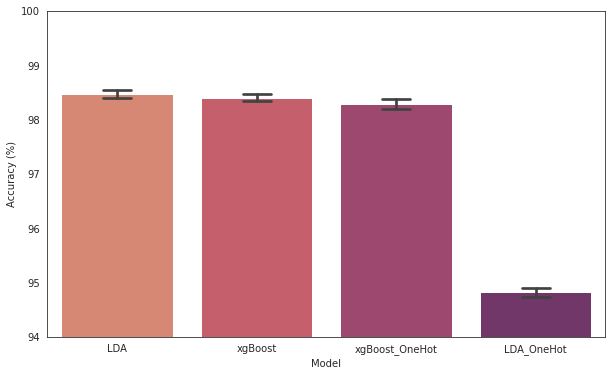

In [71]:
# barplot of accuracy with error bars
df = pd.DataFrame(res_dic)
df = df.sort_values(by='accuracy', ascending=False)
df = df.reset_index(drop=True)
df
# plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='model', y='accuracy', data=df, ax=ax, palette="flare",capsize=.2)
# ax.set_title('Accuracy of different classification models')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
ax.set_ylim(94, 100)
plt.show()

In [ ]:
res_dic_1 = {'xgBoost': [98.34, 98.39, 98.47],
             'xgBoost_OneHot': [98.2, 98.37, 98.26],
             'LDA': [98.4, 98.45, 98.54],
             'LDA_OneHot': [94.9, 94.86, 94.74]}

In [70]:
# calculate mean accuracy for each model
res_dic_avg = {key: np.mean(value) for key, value in res_dic_1.items()}
res_dic_avg

{'xgBoost': 98.40000000000002,
 'xgBoost_OneHot': 98.27666666666666,
 'LDA': 98.46333333333335,
 'LDA_OneHot': 94.83333333333333}

## Deep Neural Network

#### Deep Learning Model on Embeddings

In [195]:
# set flag to run with onehot
DNN_ONEHOT = 1

In [196]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x, y):
        # self.x = torch.tensor(x, dtype=torch.float32).to('cuda')
        # self.y = torch.tensor(y, dtype=torch.float32).to('cuda')
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        assert self.x.shape[0] == self.y.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [197]:
BATCH_SIZE = 1024

# create datasets
if DNN_ONEHOT==0:
    trainset = dataset(train_embeddings, embed_train_labels_num)
    validset = dataset(validation_embeddings, embed_val_labels_num)
else:
    trainset = dataset(train_seqs_stack, train_labels_num)
    validset = dataset(valid_seqs_stack, val_labels_num)

# DataLoader with 10 workers
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True)

In [198]:
#defining the network
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, input_shape, num_classes=len(collections.Counter(gene_data_edit[gene_column]))):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,num_classes)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [199]:
# hyper parameters
learning_rate = 0.00001

# set input shape
input_shape = train_embeddings.shape[1]
if DNN_ONEHOT:
    input_shape = train_seqs_stack.shape[1]

# Model , Optimizer, Loss
device = 'cpu'
model = Net(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [200]:
params = list(model.parameters())
print(len(params))

6


In [201]:
# calculate accuracy multi-class
def calculate_accuracy(y_pred, y_test):
    y_pred_tag = torch.argmax(y_pred, dim=1)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [202]:
def train_classify(model, trainloader, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.train()
    for train_embedding, train_label in tqdm.notebook.tqdm(trainloader, total=len(trainloader)):
        # option to move train_embedding, train_label to gpu here
        # calculate output
        train_embedding, train_label =  train_embedding.to(device), train_label.to(device)
        output = model(train_embedding)

        # calculate loss
        loss = F.cross_entropy(output, train_label.reshape(-1).long())
        
        # accuracy
        acc = calculate_accuracy(output, train_label)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += len(train_label)
    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [203]:
def evaluate_classify(model, validloader): 
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.eval()
    label_list = []
    pred_label_list = []
    with torch.no_grad(): 
        for valid_embedding, valid_label in tqdm.notebook.tqdm(validloader, total=len(validloader)):
            # option to move valid_embedding, valid_label to gpu here
            valid_embedding, valid_label = valid_embedding.to(device), valid_label.to(device)
            # calculate output
            output = model(valid_embedding)

            # calculate loss
            loss = F.cross_entropy(output, valid_label.reshape(-1).long())

            # accuracy
            acc = calculate_accuracy(output, valid_label)
            
            # add to lists for confusion matrixv
            label_list.append(valid_label.cpu())
            pred_label_list.append(output.cpu())
            
            #acc = calculate_accuracy(output, valid_label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += len(valid_label)
    return (epoch_loss / len(validloader), epoch_acc / len(validloader),
            torch.cat(label_list, dim=0), 
            torch.cat(pred_label_list, dim=0))

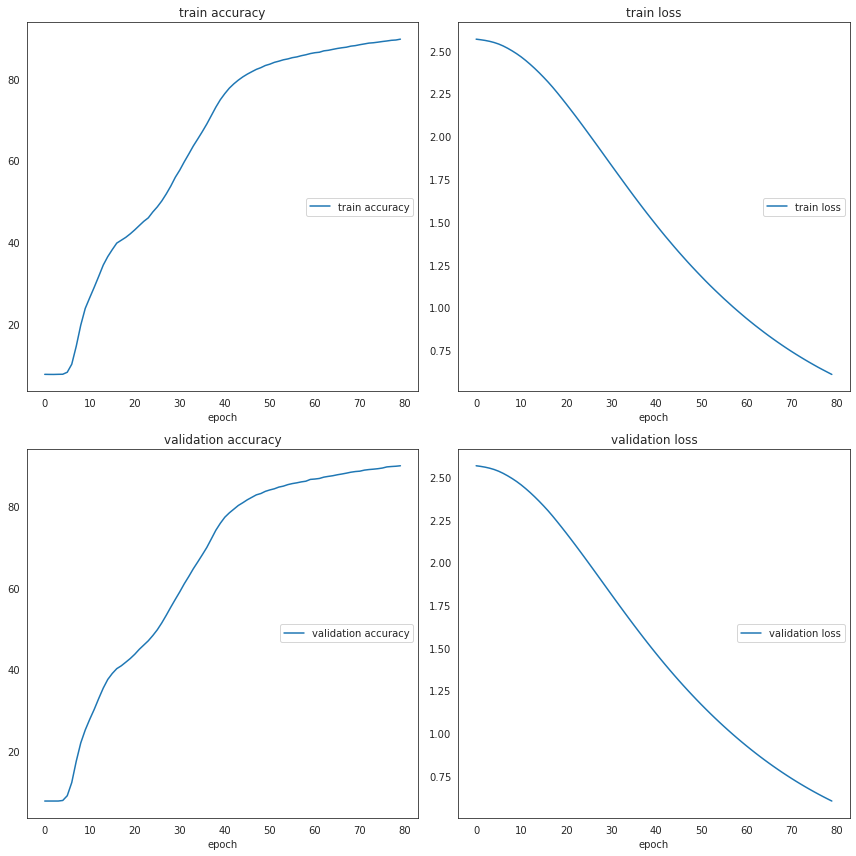

train accuracy
	train accuracy   	 (min:    7.688, max:   89.735, cur:   89.735)
train loss
	train loss       	 (min:    0.609, max:    2.569, cur:    0.609)
validation accuracy
	validation accuracy 	 (min:    7.698, max:   89.977, cur:   89.977)
validation loss
	validation loss  	 (min:    0.603, max:    2.566, cur:    0.603)


In [204]:
from livelossplot import PlotLosses
liveloss1_class = PlotLosses()
logs_class = {}
EPOCHS=80

for epoch in range(EPOCHS):
    print('starting epoch {}'.format(epoch))
    train_loss, train_acc = train_classify(model, trainloader, optimizer)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, EPOCHS, train_loss))
    
    print('Epoch {} of {}, Train Accuracy: {:.3f}'.format(
          epoch+1, EPOCHS, train_acc))
    
    logs_class['train loss'] = train_loss
    logs_class['train accuracy'] = train_acc

    valid_loss, valid_acc, label_list, pred_label_list  = evaluate_classify(model, validloader)
    print('Epoch {} of {}, Validate Loss: {:.3f}'.format(
        epoch+1, EPOCHS, valid_loss))
    
    print('Epoch {} of {}, Validate Accuracy: {:.3f}'.format(
        epoch+1, EPOCHS, valid_acc))

    logs_class['validation loss'] = valid_loss
    logs_class['validation accuracy'] = valid_acc
        
    liveloss1_class.update(logs_class)
    liveloss1_class.send()

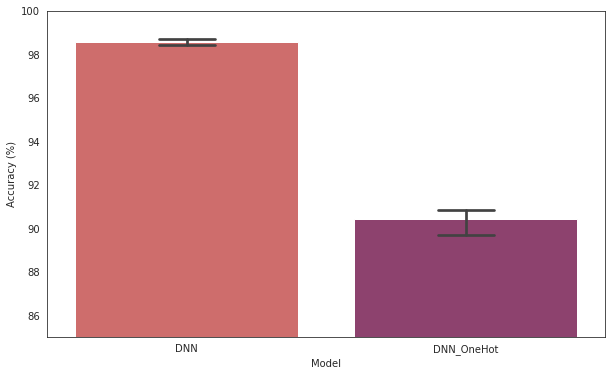

In [210]:
# dictionary
dnn_dic = {'model' : ['DNN', 'DNN', 'DNN',
                      'DNN_OneHot', 'DNN_OneHot', 'DNN_OneHot'],
           'accuracy': [98.7, 98.6, 98.412,89.7, 90.8,  90.82]}

# barplot of accuracy with error bars
df = pd.DataFrame(dnn_dic)
df = df.sort_values(by='accuracy', ascending=False)
df = df.reset_index(drop=True)
df
# plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='model', y='accuracy', data=df, ax=ax, palette="flare",capsize=.2)
# ax.set_title('Accuracy of different classification models')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
ax.set_ylim(85, 100)
plt.show()

In [212]:
dnn_dic_1 = {'DNN': [98.7, 98.6, 98.412],
             'DNN_OneHot': [89.7, 90.8,90.82]}


# calculate mean accuracy for each model
res_dnn_avg = {key: np.mean(value) for key, value in dnn_dic_1.items()}
res_dnn_avg

{'DNN': 98.57066666666667, 'DNN_OneHot': 90.44}